# Color Collection

In [1]:
import os
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
# Settings for pandas
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Settings for seaborn
sns.set(rc = {'figure.figsize':(20,8)})

In [3]:
import warnings  # To ignore warnings

def warn(*args, **kwargs):
    pass

warnings.warn = warn

## Looking for options of picking a color of an image

[reference](https://towardsdatascience.com/finding-most-common-colors-in-python-47ea0767a06a)

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

In [5]:
def show_img_compar(img_1, img_2 ):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off') #hide the axis
    ax[1].axis('off')
    f.tight_layout()
    plt.show()

#### Samples

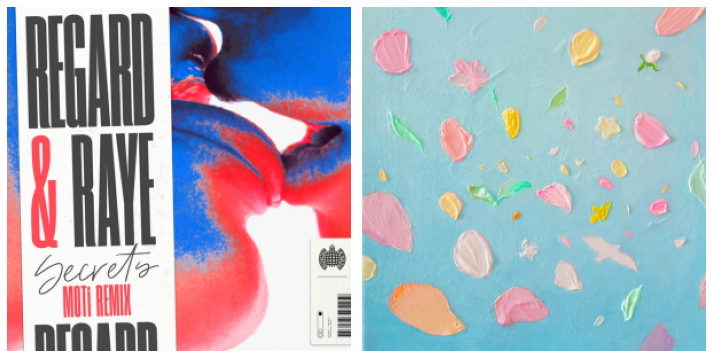

In [6]:
img = cv.imread("sample_img_1.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_2 = cv.imread("sample_img_2.jpg")
img_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)

dim = (300, 300)
# resize image
img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
img_2 = cv.resize(img_2, dim, interpolation = cv.INTER_AREA)

show_img_compar(img, img_2)

### Average

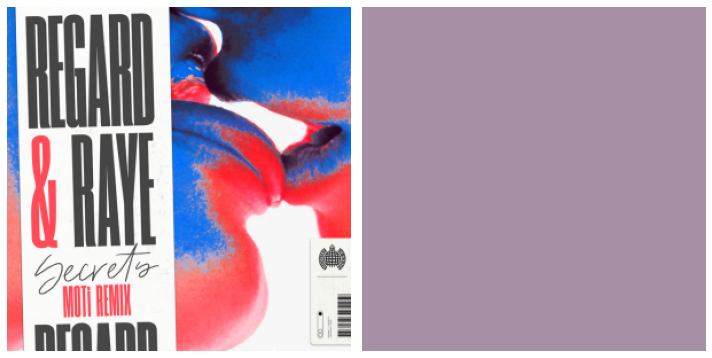

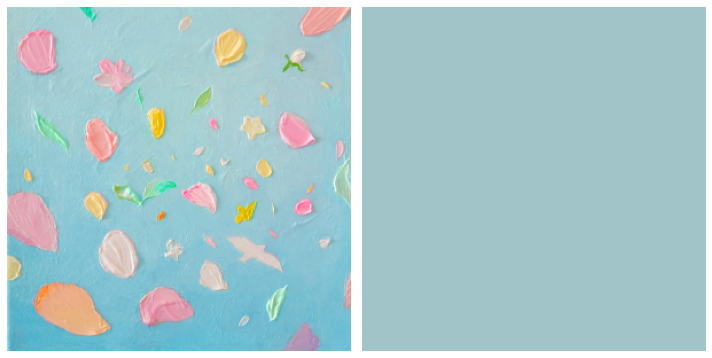

In [7]:
img_temp = img.copy()
img_temp[:,:,0], img_temp[:,:,1], img_temp[:,:,2] = np.average(img, axis=(0,1))

img_temp_2 = img_2.copy()
img_temp_2[:,:,0], img_temp_2[:,:,1], img_temp_2[:,:,2] = np.average(img_2, axis=(0,1))

show_img_compar(img, img_temp)
show_img_compar(img_2, img_temp_2)

### Most frequent

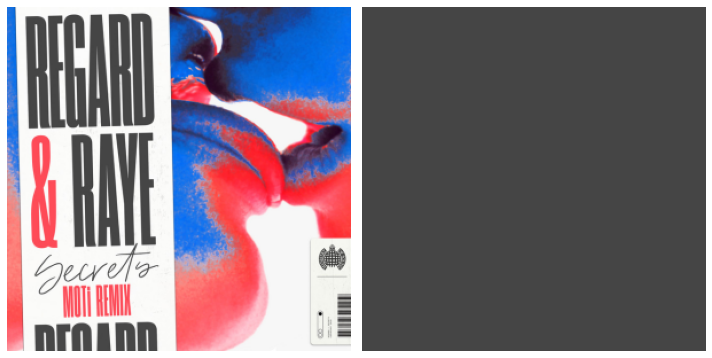

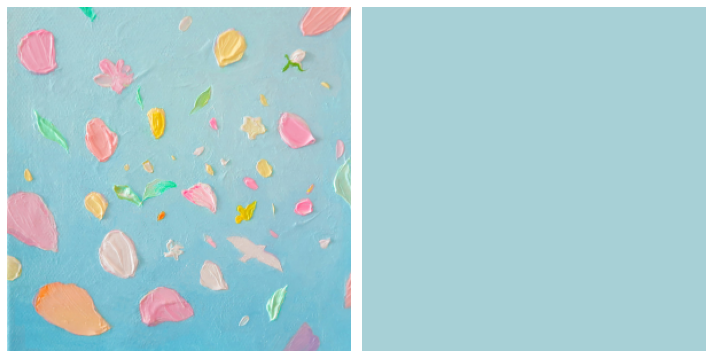

In [8]:
img_temp = img.copy()
unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
img_temp[:,:,0], img_temp[:,:,1], img_temp[:,:,2] = unique[np.argmax(counts)]

img_temp_2 = img_2.copy()
unique, counts = np.unique(img_temp_2.reshape(-1, 3), axis=0, return_counts=True)
img_temp_2[:,:,0], img_temp_2[:,:,1], img_temp_2[:,:,2] = unique[np.argmax(counts)]

show_img_compar(img, img_temp)
show_img_compar(img_2, img_temp_2)

### KMeans clustering

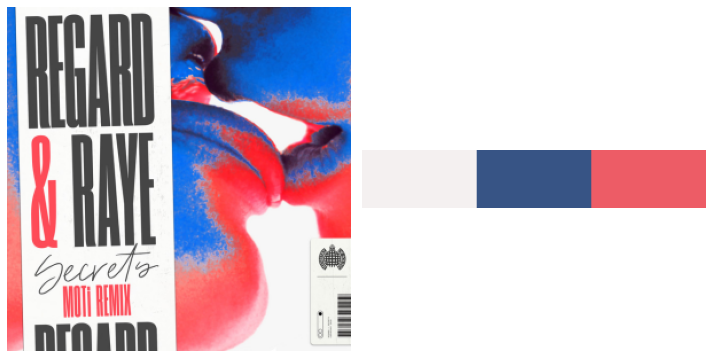

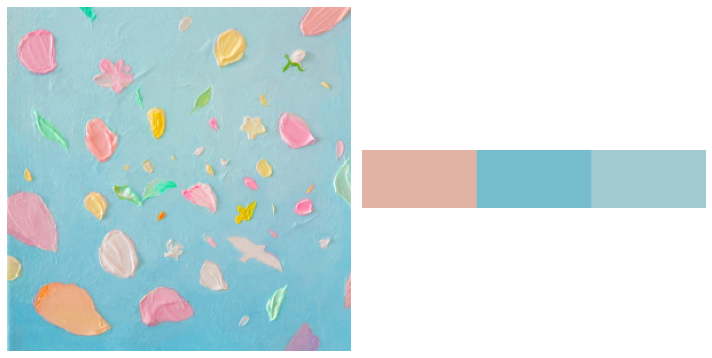

In [9]:
from sklearn.cluster import KMeans

clt = KMeans(n_clusters = 3)

def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

  
clt_1 = clt.fit(img.reshape(-1, 3))
show_img_compar(img, palette(clt_1))

clt_2 = clt.fit(img_2.reshape(-1, 3))
show_img_compar(img_2, palette(clt_2))

### KMeans clustering + proportion

{0: 0.22, 1: 0.37, 2: 0.41}
[[237.79811128  92.25171006 102.19458908]
 [244.41808498 240.65844442 240.47084028]
 [ 55.93796533  84.55852943 133.63833487]]


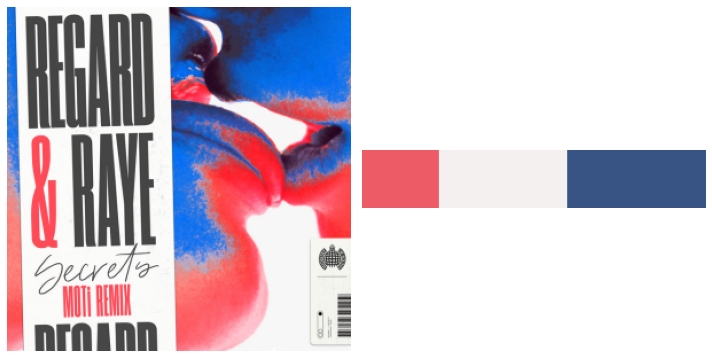

{0: 0.57, 1: 0.17, 2: 0.26}
[[161.35145265 203.68556281 209.51409928]
 [225.84373564 179.35722255 165.53448842]
 [118.70130205 190.37858279 205.75978686]]


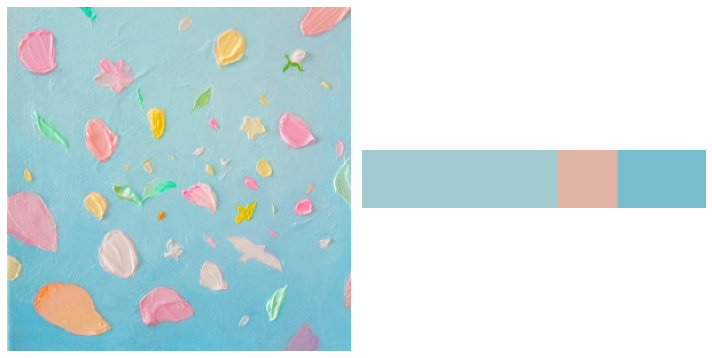

In [10]:
from collections import Counter

clt = KMeans(n_clusters = 3)

def palette_perc(k_cluster):
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items()))
    
    #for logging purposes
    print(perc)
    print(k_cluster.cluster_centers_)
    
    step = 0
    
    for idx, centers in enumerate(k_cluster.cluster_centers_): 
        palette[:, step:int(step + perc[idx]*width+1), :] = centers
        step += int(perc[idx]*width+1)
        
    return palette
    
clt_1 = clt.fit(img.reshape(-1, 3))
show_img_compar(img, palette_perc(clt_1))

clt_2 = clt.fit(img_2.reshape(-1, 3))
show_img_compar(img_2, palette_perc(clt_2))

## The name of the color or its closest

[reference (fraxel's answer)](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python)  
"The closest matching name for the requested RGB colour is measured by Euclidian distance in the RGB space."

In [11]:
import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

requested_colour = (161, 203, 209)
actual_name, closest_name = get_colour_name(requested_colour)

print("Actual colour name:", actual_name, ", closest colour name:", closest_name)

Actual colour name: None , closest colour name: lightsteelblue


## Getting the colors of images in a single emotion group

#### 데이터 불러오기

In [12]:
emotions = ['happy', 'sad', 'relaxed', 'angry']

In [13]:
path = 'C:\\Users\\admin\\Documents\\Academics\\JupyterLab\\CUAI 동계 컨퍼런스\\album\\emotion_album_images\\'

#### Getting the color of 'average' and  'Kmeans(K=3) clustering + proportion's color with the biggest proportion' and its or its closest color names

## Getting the colors of images in each emotion group

In [14]:
from PIL import Image
import glob
from sklearn.cluster import KMeans

clt = KMeans(n_clusters = 3)

total_avg_color_dict = {}  # A dict to store all the names of the average colors in each emotion group
total_k_color_dict = {}  # A dict to store all the names of the biggest proportion's colors in each emotion group


# For each emotion

for item in emotions:
    # Loading images from an emotion group
    img_array_list = []  # A list to store all arrays of images in an emotion group
    
    print("Loading images of '%s'..." % item)
    for filename in glob.glob(path+item+'/*.jpg'): 
        arr = np.array(Image.open(filename).resize((150,150)))  # Loading the image and converting it into an np array
        if arr.shape == (150,150,3):  # There were some cases where the image was not in this shape and it was causing an error, so this is a quick fix
            img_array_list.append(arr)  # Only dealing with images whose array is in shape of (150,150,3)

    # Getting the colors from each image
    avg_color_list = []  # A list to store all the names of average color in an emotion group
    k_color_list = []  # A list to store all the names of the biggest proportion's color in an emotion group
    
    for img in tqdm(img_array_list):
        avg_actual_name, avg_closest_name = get_colour_name(np.average(img, axis=(0,1)))  # Getting the name of the average color
        clusters = clt.fit(img.reshape(-1,3))  # Fitting the KMeans (K=3)
        # Getting the name of the biggest proportions's color
        k_actual_name, k_closest_name = get_colour_name(clusters.cluster_centers_[np.argmax(np.bincount(clusters.labels_))])
        
        if actual_name == None:  # Storing the closest name of a color if its actual name doesn't exist
            avg_color_list.append(avg_closest_name)
            k_color_list.append(k_closest_name)
        else:
            avg_color_list.append(avg_actual_name)
            k_color_list.append(k_closest_name)
            
    total_avg_color_dict[item] = avg_color_list
    total_k_color_dict[item] = k_color_list

Loading images of 'happy'...


100%|████████████████████████████████████████████████████████████████████████████| 15292/15292 [28:57<00:00,  8.80it/s]


Loading images of 'sad'...


100%|████████████████████████████████████████████████████████████████████████████| 14896/14896 [29:06<00:00,  8.53it/s]


Loading images of 'relaxed'...


100%|████████████████████████████████████████████████████████████████████████████| 19410/19410 [39:23<00:00,  8.21it/s]


Loading images of 'angry'...


100%|████████████████████████████████████████████████████████████████████████████| 13026/13026 [27:32<00:00,  7.88it/s]


In [16]:
import pickle
import gzip

# save and compress.
with gzip.open('colors.pickle', 'wb') as f:
    pickle.dump((total_avg_color_dict,total_k_color_dict), f)

'''
# load and uncompress.
with gzip.open('colors.pickle','rb') as f:
    data = pickle.load(f)  # data[0]: total_avg_color_dict, data[1]: total_k_color_dict
'''

"\n# load and uncompress.\nwith gzip.open('colors.pickle','rb') as f:\n    data = pickle.load(f)  # data[0]: total_avg_color_dict, data[1]: total_k_color_dict\n"